PRACTICAL ASSIGNMENT ML I: Altering the KNN algorithm by assigning weights to datapoints in order to improve the F1-score metric of binary classification targets in heavily imbalanced numeric datasets.

In [1]:
import openml
import warnings

from mla.knn import KNNClassifier as mlaKNNClassifier
from mla.metrics import accuracy

from wei import KNNClassifier as weiKNNClassifier
from wei import KNNRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def run_benchmark():
    results = pd.DataFrame(columns=["dataset", "model", "score"]) 
    
    set_ids = [40983, 1464, 1487, 1494, 1489, 1068, 1067, 1063, 1050, 1049]
        
    KNN = make_pipeline(SimpleImputer(strategy='constant'), StandardScaler(), mlaKNNClassifier(k=5))
    KNN2 = make_pipeline(SimpleImputer(strategy='constant'), StandardScaler(), weiKNNClassifier(k=5))
    models = [KNN, KNN2]
    model_names = ["KNN", "KNN2"]

    # Iterate over the subset of tasks
    for set_id in set_ids:
        dataset = openml.datasets.get_dataset(set_id, download_data=True)  
        X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
        train_models(X, y)
        for model_idx in range(len(models)):
            model = models[model_idx]
            score = np.mean(cross_val_score(models[model_idx], X, y, cv=10, scoring="roc_auc_ovr"))
            model_name = model_names[model_idx] if model_names else str(model)
            results = pd.concat([results, pd.DataFrame([[set_id, model_name, score]], columns=results.columns)],
                                ignore_index=True)
    results.to_csv("results.csv", index=False)
    

In [4]:
knn = mlaKNNClassifier(k=5)
knn2 = mlaKNNClassifier(k=5)

In [5]:
def train_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    knn2.fit(X_train, y_train)
    y_pred2 = knn2.predict(X_test)
    acc = accuracy(y_test, y_pred)
    print("Accuracy: ", acc)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score: ", f1)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1_per_class = 2 * (precision * recall) / (precision + recall)
    print("Precision per class: ", precision)
    print("Recall per class: ", recall)
    print("F1 Score per class: ", f1_per_class)

In [6]:
run_benchmark()

Accuracy:  0.9762396694214877
F1 Score:  0.9730950356532211
Precision per class:  [0.97547974 1.        ]
Recall per class:  [1.         0.56603774]
F1 Score per class:  [0.9875877  0.72289157]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.7866666666666666
F1 Score:  0.765079365079365
Precision per class:  [0.83333333 0.44444444]
Recall per class:  [0.91666667 0.26666667]
F1 Score per class:  [0.87301587 0.33333333]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.9349112426035503
F1 Score:  0.9180883022303141
Precision per class:  [0.94578313 0.33333333]
Recall per class:  [0.98742138 0.1       ]
F1 Score per class:  [0.96615385 0.15384615]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.8293838862559242
F1 Score:  0.8310351738368302
Precision per class:  [0.88888889 0.72368421]
Recall per class:  [0.85106383 0.78571429]
F1 Score per class:  [0.86956522 0.75342466]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.8649398704902868
F1 Score:  0.8626940198962983
Precision per class:  [0.88861076 0.79787234]
Recall per class:  [0.92568449 0.71656051]
F1 Score per class:  [0.90676884 0.75503356]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.9414414414414415
F1 Score:  0.9311365855019106
Precision per class:  [0.9537037 0.5      ]
Recall per class:  [0.98564593 0.23076923]
F1 Score per class:  [0.96941176 0.31578947]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.8815165876777251
F1 Score:  0.8656050718344458
Precision per class:  [0.90609137 0.53571429]
Recall per class:  [0.96486486 0.28846154]
F1 Score per class:  [0.93455497 0.375     ]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.8
F1 Score:  0.7851273238556475
Precision per class:  [0.84444444 0.53333333]
Recall per class:  [0.91566265 0.36363636]
F1 Score per class:  [0.87861272 0.43243243]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.8913738019169329
F1 Score:  0.8658742621974334
Precision per class:  [0.91447368 0.11111111]
Recall per class:  [0.97202797 0.03703704]
F1 Score per class:  [0.94237288 0.05555556]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

Accuracy:  0.863013698630137
F1 Score:  0.8292356709602671
Precision per class:  [0.88256228 0.36363636]
Recall per class:  [0.97254902 0.10810811]
F1 Score per class:  [0.92537313 0.16666667]


C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: predict_proba.

  warnings.warn(
C:\Users\lemon\Desktop\CC2008AC\PLs\knn-class-imbalance\venv\lib\s

In [7]:
# Load results and calculate average rank
results = pd.read_csv("results.csv")
avg_rank = results.groupby('dataset').score.rank(pct=True).groupby(results.model).mean()
avg_rank

model
KNN    NaN
KNN2   NaN
Name: score, dtype: float64

In [8]:
results

,dataset,model,score
0,40983,KNN,NaN
1,40983,KNN2,NaN
2,1464,KNN,NaN
3,1464,KNN2,NaN
4,1487,KNN,NaN
5,1487,KNN2,NaN
6,1494,KNN,NaN
7,1494,KNN2,NaN
8,1489,KNN,NaN
9,1489,KNN2,NaN


In [9]:
# Plot cross-validation results
def plot_cv(results_cv, metric='Accuracy'):
    fig, ax = plt.subplots()
    ax.boxplot(results_cv)
    ax.set_xticklabels(results_cv.columns)
    ax.set_ylabel(metric)
    ax.set_title('Cross-validation results for KNN and KNN2 in a dataset')
    plt.show()

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

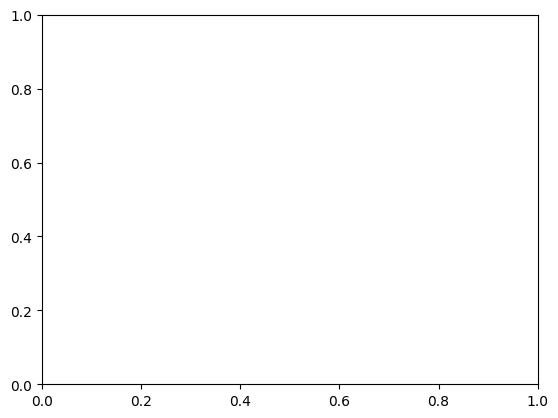

In [10]:
plot_cv(results, metric='Accuracy')

In [ ]:
data = {
    'Dataset': ['40983', '1464', '1487', '1494', '1489', '1068', '1067', '1063', '1050', '1049'],
    'KNN_Accuracy': [0.9762396694214877, 0.7866666666666666, 0.9349112426035503, 0.8293838862559242, 0.8649398704902868, 0.9414414414414415, 0.8815165876777251, 0.8, 0.8913738019169329, 0.863013698630137],
    'KNN2_Accuracy': [0.9793388429752066, 0.7533333333333333, 0.9349112426035503, 0.8483412322274881, 0.8899167437557817, 0.9369369369369369, 0.8507109004739337, 0.780952380952381, 0.8722044728434505, 0.8595890410958904],
    'KNN_F1': [0.9730950356532211, 0.765079365079365, 0.9180883022303141, 0.8310351738368302, 0.8626940198962983, 0.9311365855019106, 0.8656050718344458, 0.7851273238556475, 0.8658742621974334, 0.8292356709602671],
    'KNN2_F1': [0.9770480647859083, 0.7446382189239332, 0.920465202997901, 0.8493565337303616, 0.8886373268973798, 0.9279236783953765, 0.8317656323221783, 0.7584217687074829, 0.861973166771247, 0.8309572511828757]
}

df = pd.DataFrame(data)

In [ ]:
# Plot accuracy for KNN and KNN2
plt.figure(figsize=(12, 6))
plt.plot(df['Dataset'], df['KNN_Accuracy'], marker='o', label='KNN Accuracy')
plt.plot(df['Dataset'], df['KNN2_Accuracy'], marker='o', label='KNN2 Accuracy')
plt.xlabel('Dataset ID')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN and KNN2 across Datasets')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot F1 scores for KNN and KNN2
plt.figure(figsize=(12, 6))
plt.plot(df['Dataset'], df['KNN_F1'], marker='o', label='KNN F1 Score')
plt.plot(df['Dataset'], df['KNN2_F1'], marker='o', label='KNN2 F1 Score')
plt.xlabel('Dataset ID')
plt.ylabel('F1 Score')
plt.title('F1 Scores of KNN and KNN2 across Datasets')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
datasets = ['40983', '1464', '1487', '1494', '1489', '1068', '1067', '1063', '1050', '1049']
knn_precision_per_class = [
    [0.97547974, 1.0],
    [0.83333333, 0.44444444],
    [0.94578313, 0.33333333],
    [0.88888889, 0.72368421],
    [0.88861076, 0.79787234],
    [0.9537037, 0.5],
    [0.90609137, 0.53571429],
    [0.84444444, 0.53333333],
    [0.91447368, 0.11111111],
    [0.88256228, 0.36363636]
]

knn_recall_per_class = [
    [1.0, 0.56603774],
    [0.91666667, 0.26666667],
    [0.98742138, 0.1],
    [0.85106383, 0.78571429],
    [0.92568449, 0.71656051],
    [0.98564593, 0.23076923],
    [0.96486486, 0.28846154],
    [0.91566265, 0.36363636],
    [0.97202797, 0.03703704],
    [0.97254902, 0.10810811]
]

knn2_precision_per_class = [
    [0.97860963, 1.0],
    [0.832, 0.36],
    [0.94758065, 0.36363636],
    [0.89781022, 0.75675676],
    [0.91012658, 0.83505155],
    [0.95348837, 0.42857143],
    [0.89058524, 0.31034483],
    [0.82608696, 0.46153846],
    [0.91836735, 0.15789474],
    [0.88489209, 0.35714286]
]

knn2_recall_per_class = [
    [1.0, 0.62264151],
    [0.86666667, 0.3],
    [0.98532495, 0.13333333],
    [0.87234043, 0.8],
    [0.93741851, 0.77388535],
    [0.98086124, 0.23076923],
    [0.94594595, 0.17307692],
    [0.91566265, 0.27272727],
    [0.94405594, 0.11111111],
    [0.96470588, 0.13513514]
]

In [ ]:
def plot_precision_recall(dataset_index):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Precision plot
    axes[0].bar(['Class 0', 'Class 1'], knn_precision_per_class[dataset_index], label='KNN Precision', alpha=0.6)
    axes[0].bar(['Class 0', 'Class 1'], knn2_precision_per_class[dataset_index], label='KNN2 Precision', alpha=0.6)
    axes[0].set_title(f'Precision for Dataset {datasets[dataset_index]}')
    axes[0].set_ylabel('Precision')
    axes[0].legend()
    
    # Recall plot
    axes[1].bar(['Class 0', 'Class 1'], knn_recall_per_class[dataset_index], label='KNN Recall', alpha=0.6)
    axes[1].bar(['Class 0', 'Class 1'], knn2_recall_per_class[dataset_index], label='KNN2 Recall', alpha=0.6)
    axes[1].set_title(f'Recall for Dataset {datasets[dataset_index]}')
    axes[1].set_ylabel('Recall')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
for dataset_index in range(len(datasets)):
    plot_precision_recall(dataset_index)